# Import data

In [95]:
import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa as lr

In [103]:
# read them all
def read_device_log(device_log_path, device_id):
    with open(device_log_path) as f:
        lines = [line.rstrip() for line in f if line[0].isdigit()]
    
    df = pd.DataFrame(lines, columns=["line"])
    df = df["line"].str.split(",", expand=True)
    # rename columns
    df.columns = ["timestamp", "file", "state"]
    # get basename column
    df["basename"] = [os.path.basename(x) for x in df["file"]]
    # each entry of the basename column is as follows: recording_20230906220501.flac
    # we want to extract the date and time from this string
    # first, we remove the extension
    basename_id = df["basename"].str.replace(".flac", "")
    # then, we remove the "recording_" prefix
    basename_id = basename_id.str.replace("recording_", "")
    # now the string is as this: 20230906220501
    # we can split it into date and time
    df["date"] = basename_id.str[:8]
    df["time"] = basename_id.str[8:]
    # convert to datetime
    df["datetime"] = pd.to_datetime(df["date"] + df["time"], format="%Y%m%d%H%M%S")
    df["device_id"] = device_id
    return df

# get the duration of each file
def get_duration(file_path):
    return lr.get_duration(filename=file_path)


In [111]:
device_folders = ["/media/alvaro/BladeHDD/Bioacoustics_BigData/Monteverde_Ubuntutouch/Experimentos/Segundo/SamsungS7/","/media/alvaro/BladeHDD/Bioacoustics_BigData/Monteverde_Ubuntutouch/Experimentos/Segundo/OneNote5/","/media/alvaro/BladeHDD/Bioacoustics_BigData/Monteverde_Ubuntutouch/Experimentos/Segundo/Pixel3a/"]
device_ids = ["SamsungS7", "OneNote5", "Pixel3a"]
device_log_paths = [device_folder + "/pam_output/pam_recorder_log.txt" for device_folder in device_folders]

devices_df = pd.concat([read_device_log(device_log_path, device_id) for device_log_path, device_id in zip(device_log_paths, device_ids)])

# add the path depending of the device id
devices_df["device_path"] = devices_df["device_id"].map(dict(zip(device_ids, device_folders)))
# that was wrong, we need a / between the two
devices_df["audio_path"] = devices_df["device_path"] + "/pam_output/" + devices_df["basename"]

# get the duration of each file
devices_df["duration"] = devices_df["audio_path"].map(get_duration)

/tmp/ipykernel_39055/2682372235.py:29: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  return lr.get_duration(filename=file_path)


In [130]:
devices_df.to_csv("devices_df.csv", index=False)

/tmp/ipykernel_39055/2846723788.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', len(df['device_id'].unique()))


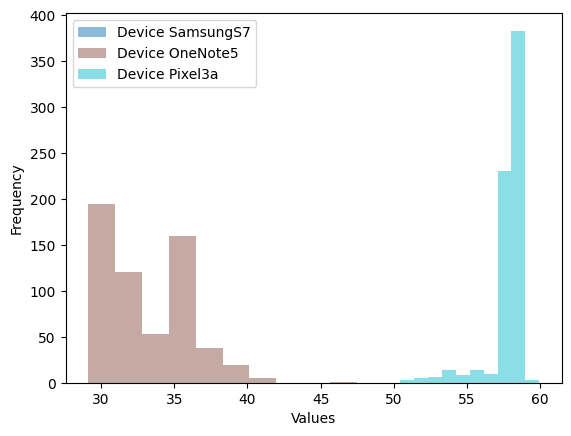

In [129]:
# Define the color map based on unique device_id values
color_map = plt.cm.get_cmap('tab10', len(df['device_id'].unique()))

# Create a figure and axis
fig, ax = plt.subplots()

# Loop through unique device_ids and plot histograms with corresponding colors
for i, device_id in enumerate(df['device_id'].unique()):
    subset = df[df['device_id'] == device_id]
    ax.hist(subset['duration'], bins=10, alpha=0.5, label=f'Device {device_id}', color=color_map(i))

# Add legend and labels
ax.legend()
ax.set_xlabel('Values')
ax.set_ylabel('Frequency')

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Get a colormap
cmap = get_cmap('tab10')  # You can choose a different colormap if you prefer

# Plot 1: Duration Histogram
plt.figure(figsize=(10, 5))
for device_id, group in devices_df.groupby('device_id'):
    duration_histplot = group['duration'].plot.hist(bins=100, color=cmap(int(device_id[-1]))) 
duration_histplot.set_xlabel("Duration (s)")
duration_histplot.set_ylabel("Count")
duration_histplot.set_title("Histogram of file durations")
plt.legend(devices_df['device_id'].unique())


/tmp/ipykernel_39055/509108279.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')  # You can choose a different colormap if you prefer


ValueError: invalid literal for int() with base 10: 'a'

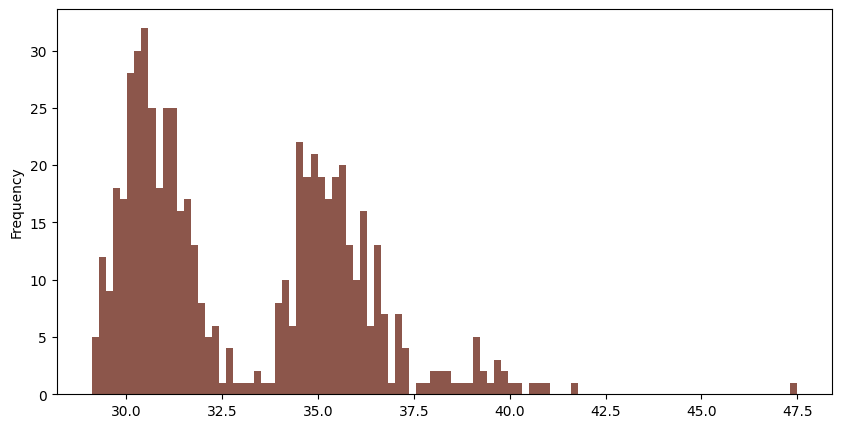

In [115]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Get a colormap
cmap = get_cmap('tab10')  # You can choose a different colormap if you prefer

# Plot 1: Duration Histogram
plt.figure(figsize=(10, 5))
for device_id, group in devices_df.groupby('device_id'):
    duration_histplot = group['duration'].plot.hist(bins=100, color=cmap(int(device_id[-1])))  
duration_histplot.set_xlabel("Duration (s)")
duration_histplot.set_ylabel("Count")
duration_histplot.set_title("Histogram of file durations")
plt.legend(devices_df['device_id'].unique())

# Plot 2: Number of Files per Day
plt.figure(figsize=(10, 5))
for device_id, group in devices_df.groupby('device_id'):
    number_of_files_per_day = group['date'].value_counts().plot.bar(color=cmap(int(device_id[-1])))  
number_of_files_per_day.set_title("Number of files per day")
number_of_files_per_day.set_xlabel("Date")
number_of_files_per_day.set_ylabel("Count")
plt.legend(devices_df['device_id'].unique())

# Plot 3: Number of Files per Hour
plt.figure(figsize=(10, 5))
for device_id, group in devices_df.groupby('device_id'):
    number_of_files_per_hour_plot = group['time'].apply(lambda x: int(x[:2])).value_counts().sort_index().plot.bar(color=cmap(int(device_id[-1])))  
number_of_files_per_hour_plot.set_title("Number of files per hour")
number_of_files_per_hour_plot.set_xlabel("Hour")
number_of_files_per_hour_plot.set_ylabel("Count")
plt.legend(devices_df['device_id'].unique())

# Plot 4: Calendar Line of Points
plt.figure(figsize=(20, 5))
for device_id, group in devices_df.groupby('device_id'):
    calendar_line_of_points_plot = plt.scatter(group["datetime"], np.zeros(len(group)), s=1, color=cmap(int(device_id[-1])))
plt.title("Calendar line of points")
plt.xlabel("Datetime")
plt.ylabel("Y-axis Label")
plt.legend(devices_df['device_id'].unique())

# Plot 5: Duration vs Datetime
plt.figure(figsize=(10, 5))
for device_id, group in devices_df.groupby('device_id'):
    duration_vs_datetime_plot = plt.plot(group["datetime"], group["duration"], '.', color=cmap(int(device_id[-1])))
plt.title("Duration vs datetime")
plt.xlabel("Datetime")
plt.ylabel("Duration (s)")
plt.legend(devices_df['device_id'].unique())

# Show all plots
plt.show()


In [102]:
devices_df

,timestamp,file,state,basename,date,time,datetime,device_id
0,20230906215618,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230906215518.flac,20230906,215518,2023-09-06 21:55:18,SamsungS7
1,20230906220101,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230906220001.flac,20230906,220001,2023-09-06 22:00:01,SamsungS7
2,20230906220601,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230906220501.flac,20230906,220501,2023-09-06 22:05:01,SamsungS7
3,20230906221101,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230906221001.flac,20230906,221001,2023-09-06 22:10:01,SamsungS7
4,20230906221601,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230906221501.flac,20230906,221501,2023-09-06 22:15:01,SamsungS7
...,...,...,...,...,...,...,...,...
671,20230909065232,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230909065018.flac,20230909,065018,2023-09-09 06:50:18,Pixel3a
672,20230909065805,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230909065557.flac,20230909,065557,2023-09-09 06:55:57,Pixel3a
673,20230909070213,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230909070004.flac,20230909,070004,2023-09-09 07:00:04,Pixel3a
674,20230909070730,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230909070534.flac,20230909,070534,2023-09-09 07:05:34,Pixel3a


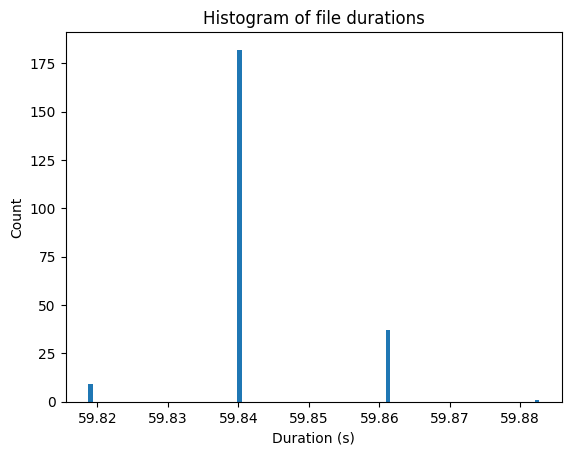

In [59]:
duration_histplot = df.duration.plot.hist(bins=100)
duration_histplot.set_xlabel("Duration (s)")
duration_histplot.set_ylabel("Count")
duration_histplot.set_title("Histogram of file durations")


Text(0, 0.5, 'Count')

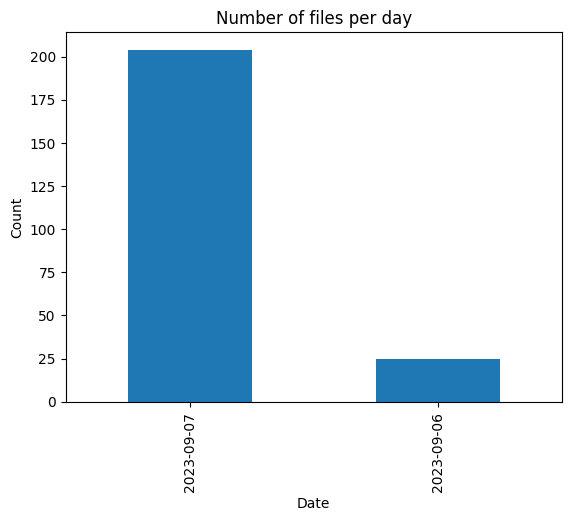

In [66]:
# lets get the number of files per day, and the total hours it was able of covering
# first, we get the number of files per day
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["date"] = df["date"].dt.date
df["date"].value_counts().plot.bar()
plt.title("Number of files per day")
plt.xlabel("Date")
plt.ylabel("Count")


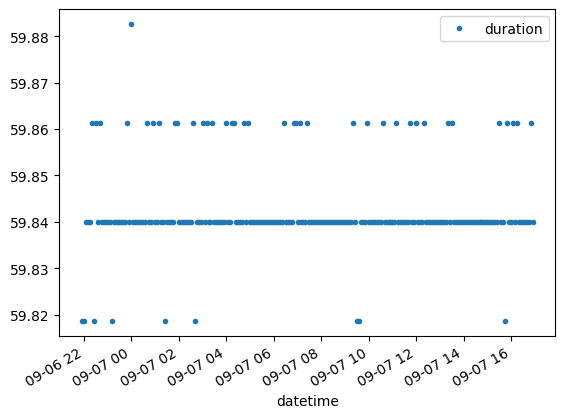

In [67]:
# now lets plot the plots vs datetime
# first, we need to convert the datetime column to a datetime object
df["datetime"] = pd.to_datetime(df["datetime"])
# now we can plot
df.plot(x="datetime", y="duration", style=".")
plt.show()


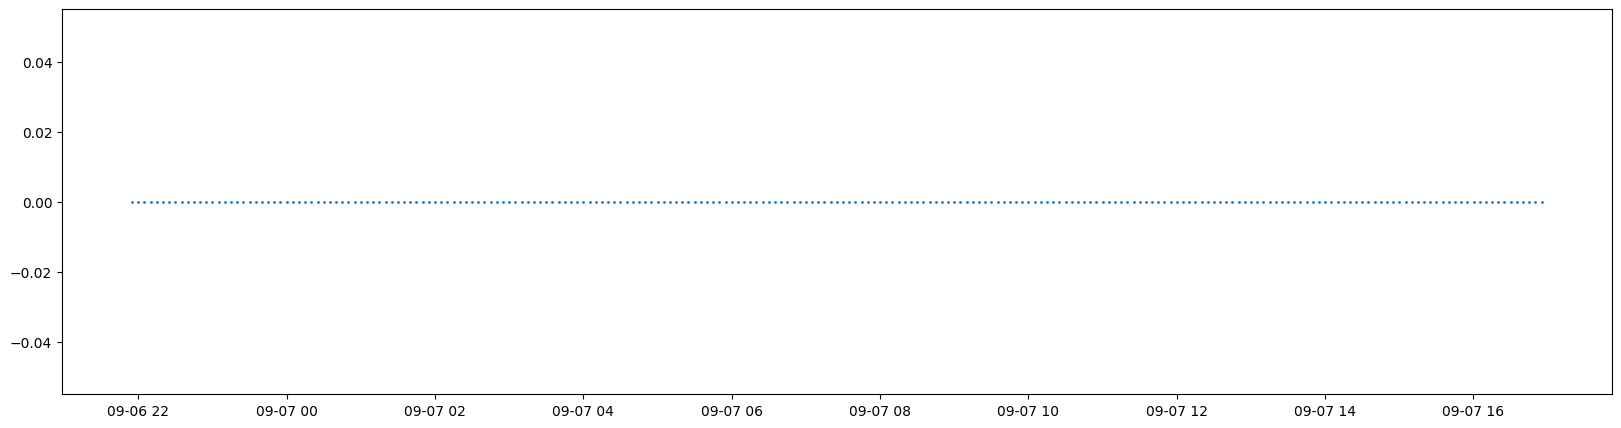

In [68]:
# now lets plot it as a calendar heatmap
# lets make the calendar heatmap
plt.figure(figsize=(20, 5))
plt.scatter(df["datetime"], np.zeros(len(df)), s=1)
plt.show()


Total hours: 18.995277777777776
Total hours of recordings: 3.806666761148905
Percentage of time it was able of covering: 20.040068935460656%


<Axes: xlabel='hour'>

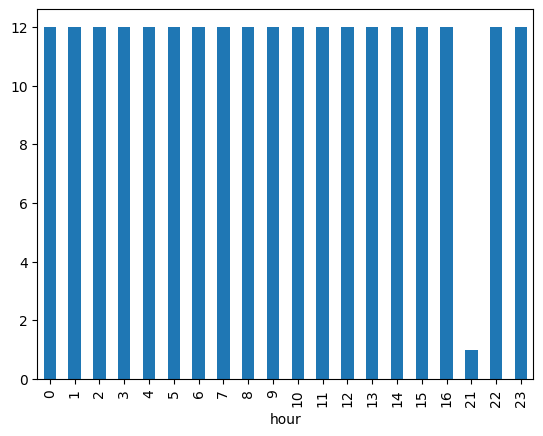

In [84]:
# lets get the total hours it was able of covering, from the first recording until the last
# first, we get the first and last datetime
first_datetime = df["datetime"].iloc[0]
last_datetime = df["datetime"].iloc[-1]
# now we get the difference between them
total_hours = (last_datetime - first_datetime).total_seconds() / 3600
print("Total hours: " + str(total_hours))
# now we get the total hours of recordings
total_hours_recordings = df["duration"].sum() / 3600
print("Total hours of recordings: " + str(total_hours_recordings))
# now we get the percentage of time it was able of covering
print("Percentage of time it was able of covering: " + str(total_hours_recordings / total_hours * 100) + "%")

# now lets get the number of files per hour
# first, we get the hour of each recording
df["hour"] = df["datetime"].dt.hour
# now we plot
df["hour"].value_counts().sort_index().plot.bar()

In [85]:
df

,timestamp,file,state,basename,date,time,datetime,duration,hour
0,20230906215618,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230906215518.flac,2023-09-06,215518,2023-09-06 21:55:18,59.818685,21
1,20230906220101,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230906220001.flac,2023-09-06,220001,2023-09-06 22:00:01,59.818685,22
2,20230906220601,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230906220501.flac,2023-09-06,220501,2023-09-06 22:05:01,59.840000,22
3,20230906221101,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230906221001.flac,2023-09-06,221001,2023-09-06 22:10:01,59.840000,22
4,20230906221601,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230906221501.flac,2023-09-06,221501,2023-09-06 22:15:01,59.840000,22
...,...,...,...,...,...,...,...,...,...
224,20230907163601,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230907163501.flac,2023-09-07,163501,2023-09-07 16:35:01,59.840000,16
225,20230907164101,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230907164001.flac,2023-09-07,164001,2023-09-07 16:40:01,59.840000,16
226,20230907164601,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230907164501.flac,2023-09-07,164501,2023-09-07 16:45:01,59.840000,16
227,20230907165101,/home/phablet/Documents/pam_output/recording_2...,success,recording_20230907165001.flac,2023-09-07,165001,2023-09-07 16:50:01,59.861338,16


In [89]:
# now lets wrap up all the code above to be able of outputting all information and plots in a single function
def inspect_device(device_folder):
    
    device_log_path = device_folder + "/pam_output/pam_recorder_log.txt"
    # read only lines that start with a number
    with open(device_log_path) as f:
        lines = [line.rstrip() for line in f if line[0].isdigit()]
    # convert to dataframe
    df = pd.DataFrame(lines, columns=["line"])
    # split into columns
    df = df["line"].str.split(",", expand=True)
    # rename columns
    df.columns = ["timestamp", "file", "state"]
    # get basename column
    df["basename"] = df["basename"] = [os.path.basename(x) for x in df["file"]]
    # each entry of the basename column is as follows: recording_20230906220501.flac
    # we want to extract the date and time from this string
    # first, we remove the extension
    basename_id = df["basename"].str.replace(".flac", "")
    # then, we remove the "recording_" prefix
    basename_id = basename_id.str.replace("recording_", "")
    # now the string is as this: 20230906220501
    # we can split it into date and time
    df["date"] = basename_id.str[:8]
    df["time"] = basename_id.str[8:]
    # convert to datetime
    df["datetime"] = pd.to_datetime(df["date"] + df["time"], format="%Y%m%d%H%M%S")

    # get the duration of each file
    df["duration"] = [lr.get_duration(filename=device_folder + "/pam_output/" + x) for x in df["basename"]]

    duration_histplot = df.duration.plot.hist(bins=100)
    duration_histplot.set_xlabel("Duration (s)")
    duration_histplot.set_ylabel("Count")
    duration_histplot.set_title("Histogram of file durations")


    # lets get the number of files per day, and the total hours it was able of covering
    # first, we get the number of files per day
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
    df["date"] = df["date"].dt.date
    number_of_files_per_day=df["date"].value_counts().plot.bar()
    number_of_files_per_day.set_title("Number of files per day")
    number_of_files_per_day.set_xlabel("Date")
    number_of_files_per_day.set_ylabel("Count")

    # now lets get the number of files per hour
    # first, we get the hour of each recording
    df["hour"] = df["datetime"].dt.hour
    return df["hour"]
    # now we plot
    print(df["hour"].value_counts().sort_index())
    number_of_files_per_hour_plot=df["hour"].value_counts().sort_index().plot.bar()
    number_of_files_per_hour_plot.set_title("Number of files per hour")
    number_of_files_per_hour_plot.set_xlabel("Hour")
    number_of_files_per_hour_plot.set_ylabel("Count")

    # now lets plot it as a calendar line of points
    # lets make the calendar heatmap
    plt.figure(figsize=(20, 5))
    calendar_line_of_points_plot = plt.scatter(df["datetime"], np.zeros(len(df)), s=1)
    plt.title("Calendar line of points")  # Set title on the entire figure

    # Optionally, you can add labels for better clarity
    plt.xlabel("Datetime")
    plt.ylabel("Y-axis Label")

    # Save the figure in the variable
    calendar_line_of_points_plot = plt.gcf()

    # now lets plot the plots vs datetime
    # first, we need to convert the datetime column to a datetime object
    df["datetime"] = pd.to_datetime(df["datetime"])
    # now we can plot
    duration_vs_datetime_plot=df.plot(x="datetime", y="duration", style=".")
    duration_vs_datetime_plot.set_title("Duration vs datetime")

    # lets get the total hours it was able of covering, from the first recording until the last
    # first, we get the first and last datetime
    first_datetime = df["datetime"].iloc[0]
    last_datetime = df["datetime"].iloc[-1]
    # now we get the difference between them
    total_hours = (last_datetime - first_datetime).total_seconds() / 3600
    print("Total hours: " + str(total_hours))
    # now we get the total hours of recordings
    total_hours_recordings = df["duration"].sum() / 3600
    print("Total hours of recordings: " + str(total_hours_recordings))
    # now we get the percentage of time it was able of covering
    print("Percentage of time it was able of covering: " + str(total_hours_recordings / total_hours * 100) + "%")
    # return all plots and info
    return duration_histplot, number_of_files_per_day, number_of_files_per_hour_plot, calendar_line_of_points_plot, duration_vs_datetime_plot

In [93]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def inspect_device(device_folder):
    # Step 1: Read and process log file
    device_log_path = os.path.join(device_folder, "pam_output", "pam_recorder_log.txt")
    with open(device_log_path) as f:
        lines = [line.rstrip() for line in f if line[0].isdigit()]
    df = pd.DataFrame(lines, columns=["line"])
    df = df["line"].str.split(",", expand=True)
    df.columns = ["timestamp", "file", "state"]
    df["basename"] = [os.path.basename(x) for x in df["file"]]
    basename_id = df["basename"].str.replace(".flac", "").str.replace("recording_", "")
    df["date"] = basename_id.str[:8]
    df["time"] = basename_id.str[8:]
    df["datetime"] = pd.to_datetime(df["date"] + df["time"], format="%Y%m%d%H%M%S")
    df["duration"] = [lr.get_duration(filename=os.path.join(device_folder, "pam_output", x)) for x in df["basename"]]

    # Step 2: Plot duration histogram
    plt.figure(figsize=(10, 5))
    duration_histplot = df.duration.plot.hist(bins=100)
    duration_histplot.set_xlabel("Duration (s)")
    duration_histplot.set_ylabel("Count")
    duration_histplot.set_title("Histogram of file durations")

    # Step 3: Plot number of files per day
    plt.figure(figsize=(10, 5))
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d").dt.date
    number_of_files_per_day = df["date"].value_counts().plot.bar()
    number_of_files_per_day.set_title("Number of files per day")
    number_of_files_per_day.set_xlabel("Date")
    number_of_files_per_day.set_ylabel("Count")

    # Step 4: Plot number of files per hour
    plt.figure(figsize=(10, 5))
    df["hour"] = df["datetime"].dt.hour
    number_of_files_per_hour_plot = df["hour"].value_counts().sort_index().plot.bar()
    number_of_files_per_hour_plot.set_title("Number of files per hour")
    number_of_files_per_hour_plot.set_xlabel("Hour")
    number_of_files_per_hour_plot.set_ylabel("Count")

    # Step 5: Calendar line of points plot
    plt.figure(figsize=(20, 5))
    calendar_line_of_points_plot = plt.scatter(df["datetime"], np.zeros(len(df)), s=1)
    plt.title("Calendar line of points")
    plt.xlabel("Datetime")
    plt.ylabel("Y-axis Label")

    # Step 6: Duration vs datetime plot
    df["datetime"] = pd.to_datetime(df["datetime"])
    duration_vs_datetime_plot = df.plot(x="datetime", y="duration", style=".")
    duration_vs_datetime_plot.set_title("Duration vs datetime")

    # Step 7: Get total hours information
    first_datetime = df["datetime"].iloc[0]
    last_datetime = df["datetime"].iloc[-1]
    total_hours = (last_datetime - first_datetime).total_seconds() / 3600
    total_hours_recordings = df["duration"].sum() / 3600
    percentage_of_time = total_hours_recordings / total_hours * 100

    print(f"Total hours: {total_hours}")
    print(f"Total hours of recordings: {total_hours_recordings}")
    print(f"Percentage of time covered: {percentage_of_time}%")

    # Return plot objects
    return (
        duration_histplot,
        number_of_files_per_day,
        number_of_files_per_hour_plot,
        calendar_line_of_points_plot,
        duration_vs_datetime_plot
    )


In [87]:
device_folder

'/media/alvaro/BladeHDD/Bioacoustics_BigData/Monteverde_Ubuntutouch/Experimentos/Segundo/SamsungS7/'

/tmp/ipykernel_39055/762815805.py:19: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  df["duration"] = [lr.get_duration(filename=os.path.join(device_folder, "pam_output", x)) for x in df["basename"]]


Total hours: 18.995277777777776
Total hours of recordings: 3.806666761148905
Percentage of time covered: 20.040068935460656%


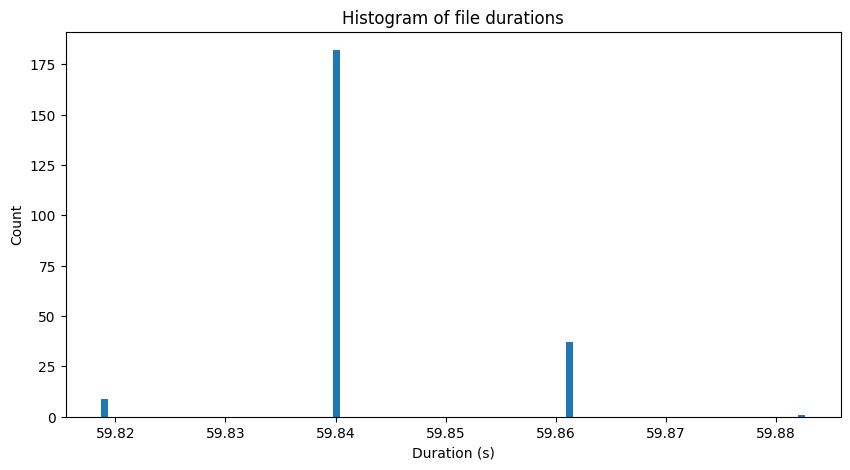

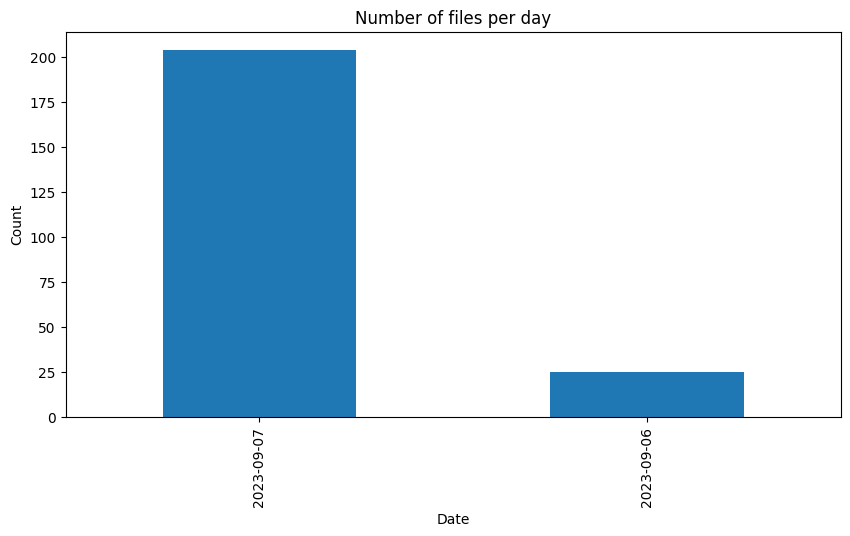

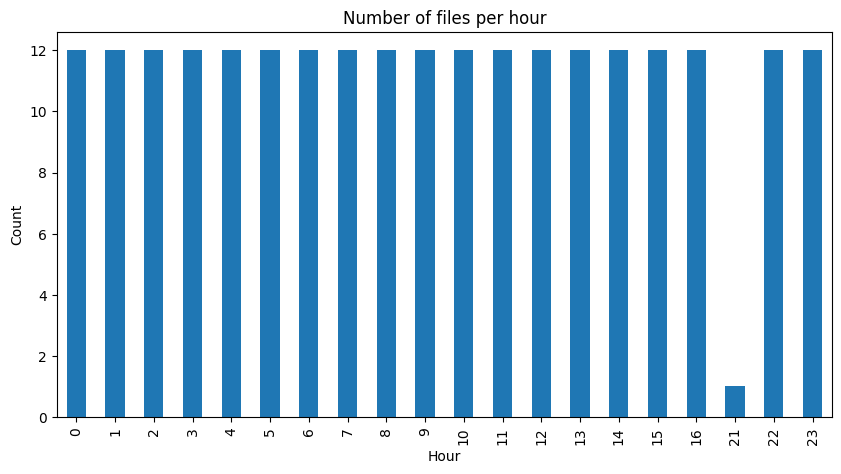

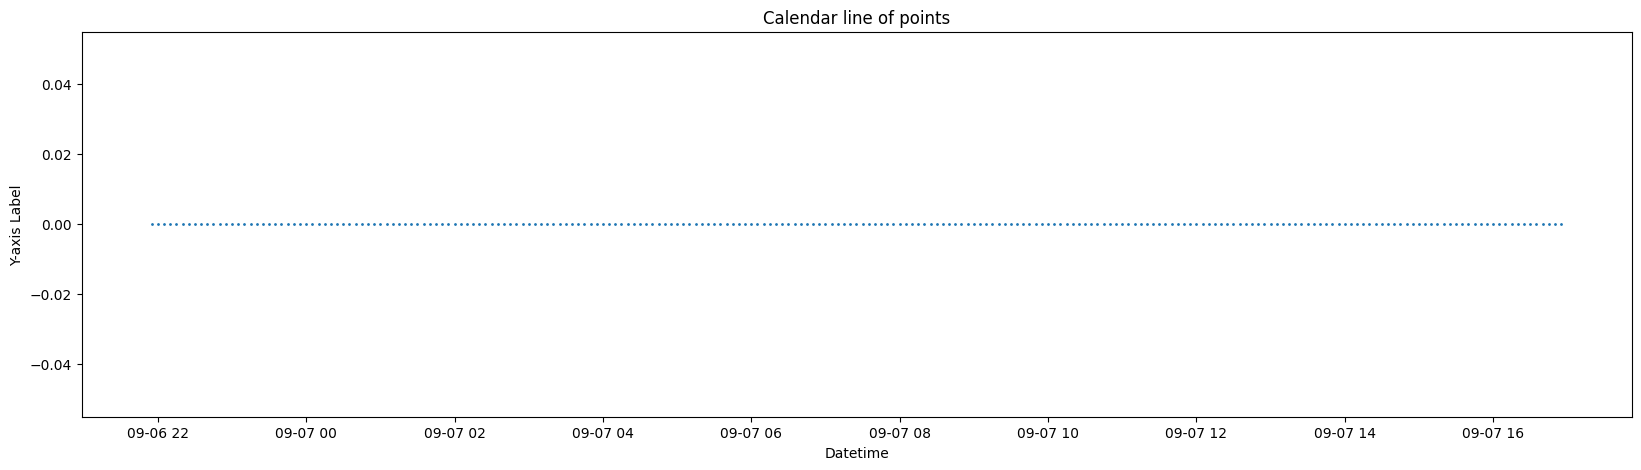

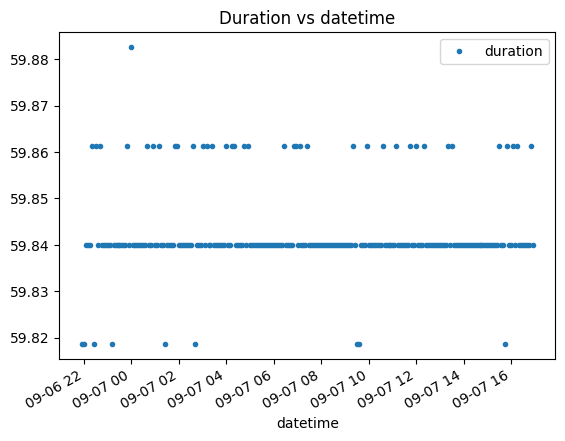

In [94]:
# now lets test it
h=inspect_device(device_folder)

In [92]:
h.

0      21
1      22
2      22
3      22
4      22
       ..
224    16
225    16
226    16
227    16
228    16
Name: hour, Length: 229, dtype: int32